# Training without Data

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Drenderer/klax/blob/main/docs/examples/training_without_data.ipynb)

This example demonstrates one possible way of training a PINNs-style model without any data using [`klax.fit`][].

To run it locally install klax with plotting capability via `pip install 'klax[plot]'`.

We start by importing the required packages for model creation, optimization and plotting.

In [1]:
import equinox as eqx
import jax
import jax.numpy as jnp
import jax.random as jr
import optax
from jaxtyping import Array, PRNGKeyArray
from matplotlib import pyplot as plt

import klax

Here we want to find the solution $u:\mathbb{R}\rightarrow\mathbb{R}$ of the ODE:
$$
\begin{equation}
    \frac{\partial u}{\partial x} + u = 0, \quad u(x=0)=1
\end{equation}
$$

The following code cell implements a PINN model, that uses a small [`klax.nn.MLP`][] to represent the solution.
We also tie the residual loss from the ODE to the PINN implementation as a static method. The PINN instance will store the residual evaluation points $x_i$ in the attribute `x_collocation`.

!!! note

    Fore more complex PINN training, writing a custom fit method with random sampling of collocation points, gradient-based loss balancing and other optimization methods may be preferred. For more information see e.g. [Wang et al. (2023) "An Expert's Guide to Training Physics-informed Neural Network"](https://arxiv.org/abs/2308.08468). Meanwhile, the goal of this example is simply to show how training without data could be implemented using Klax.



In [2]:
class PINN(eqx.Module):
    """A simple PINN-style model that solves the ODE u_x + u = 0 with u(0) = 1."""

    mlp: klax.nn.MLP
    x_collocation: Array  # Residual evaluation points

    def __init__(self, x_collocation: Array, key: PRNGKeyArray):
        self.x_collocation = x_collocation
        self.mlp = klax.nn.MLP(
            "scalar", "scalar", 2 * [16], activation=jax.nn.softplus, key=key
        )

    def __call__(self, x):
        return self.mlp(x)

    @staticmethod
    def residural_loss(model, batch, batch_axis):
        """Residual loss definition.

        We define a loss function that penalizes the residual of the ODE
        u_x + u = 0 and violations of the boundary conditions u(0) = 1.
        """
        # Manually exclude x_collocation from optimization
        x_collocation = jax.lax.stop_gradient(model.x_collocation)

        # ODE residual
        u = jax.vmap(model)(x_collocation)
        u_xx = jax.vmap(jax.grad(model))(x_collocation)
        residual = u_xx + u
        residual_loss = jnp.mean(residual**2)

        # Boundary conditions
        bc_0 = model(jnp.array(0.0)) - 1.0
        bc_loss = bc_0**2

        return residual_loss + 0.1 * bc_loss  # Manual loss balancing

Lets train the model. First we provide the residual evaluation points to initialize the PINN model. Here we choose $x_i \in [0,1]$. Then we fit the model. Note that we use `data=None` as the evaluation points are stored within the model itself. Importantly, we also have to specify that our data does not have any `batch_axis`.

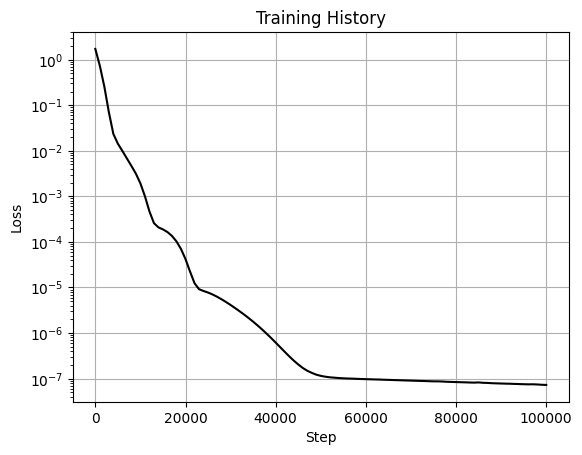

In [3]:
x_collocation = jnp.linspace(0, 1, 100)
model_key, training_key = jr.split(jr.key(0))
model = PINN(x_collocation, key=model_key)

model, history = klax.fit(
    model,
    data=None,
    batch_axis=None,
    steps=100_000,
    optimizer=optax.adam(1e-5),
    loss_fn=model.residural_loss,
    history=klax.HistoryCallback(log_every=1000, verbose=False),
    key=training_key,
)

history.plot()

Finally, lets have a look at the model performance on the interval $[0,4]$ and compare it to the analytically calculalted solution $u(x)=e^{-x}$.

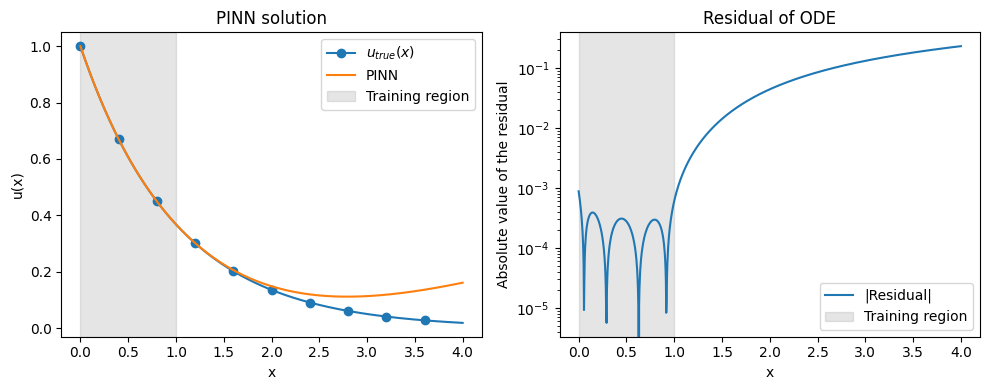

In [4]:
def solution(x):
    """Return the true solution of the ODE u_x + u = 0 with u(0) = 1."""
    return jnp.exp(-x)


x = jnp.linspace(0, 4, 1000)
u_true = jax.vmap(solution)(x)
u = jax.vmap(model)(x)
u_x = jax.vmap(jax.grad(model))(x)
residual = u_x + u

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].plot(x, u_true, marker="o", markevery=100, label=R"$u_{true}(x)$")
axes[0].plot(x, u, label="PINN")
axes[0].set(
    title="PINN solution",
    xlabel="x",
    ylabel="u(x)",
)
axes[0].axvspan(
    model.x_collocation.min(),
    model.x_collocation.max(),
    color="gray",
    alpha=0.2,
    label="Training region",
)
axes[0].legend()

axes[1].plot(x, jnp.abs(residual), label="|Residual|")
axes[1].set(
    title="Residual of ODE",
    xlabel="x",
    ylabel="Absolute value of the residual",
    yscale="log",
)
axes[1].axvspan(
    model.x_collocation.min(),
    model.x_collocation.max(),
    color="gray",
    alpha=0.2,
    label="Training region",
)
axes[1].legend()

plt.tight_layout()
plt.show()